# Python Profiling for High performance

### Julia Set

The Julia set is an interesting CPU-bound problem for us to begin with. It is a fractal sequence that generates a complex output image, named after Gaston Julia.

The code that follows is a little longer than a version you might write yourself. It has a CPU-bound component and a very explicit set of inputs. This configuration allows us to profile both the CPU usage and the RAM usage so we can understand which parts of our code are consuming two of our scarce computing resources. This implementation is deliberately suboptimal, so we can identify memory-consuming operations and slow statements.

We will analyze a block of code that produces both a false grayscale plot and a pure grayscale variant of the Julia set, at the complex point c=-0.62772-0.42193j. A Julia set is produced by calculating each pixel in isolation; this is an “embarrassingly parallel problem,” as no data is shared between points.

In [5]:
import time
from PIL import Image
import array
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

In [ ]:
def show_greyscale(output_raw, width, height, max_iterations):
    """Convert list to array, show using PIL"""
    # convert our output to PIL-compatible input
    # scale to [0...255]
    max_iterations = float(max(output_raw))
    print(max_iterations)
    scale_factor = float(max_iterations)
    scaled = [int(o / scale_factor * 255) for o in output_raw]
    output = array.array('B', scaled)  # array of unsigned ints
    # display with PIL
    im = Image.new("L", (width, width))
    # EXPLAIN RAW L 0 -1
    im.frombytes(output.tobytes(), "raw", "L", 0, -1)
    # im.show()
    display(im)

In [ ]:
def show_false_greyscale(output_raw, width, height, max_iterations):
    """Convert list to array, show using PIL"""
    # convert our output to PIL-compatible input
    assert width * height == len(output_raw)  # sanity check our 1D array and desired 2D form
    # rescale output_raw to be in the inclusive range [0..255]
    max_value = float(max(output_raw))
    output_raw_limited = [int(float(o) / max_value * 255) for o in output_raw]
    # create a slightly fancy colour map that shows colour changes with
    # increased contrast (thanks to John Montgomery)
    output_rgb = ((o + (256 * o) + (256 ** 2) * o) * 16 for o in output_raw_limited)  # fancier
    output_rgb = array.array('I', output_rgb)  # array of unsigned ints (size is platform specific)
    # display with PIL/pillow
    im = Image.new("RGB", (width, height))
    # EXPLAIN RGBX L 0 -1
    im.frombytes(output_rgb.tobytes(), "raw", "RGBX", 0, -1)
    # im.show()
    display(im)

In [ ]:
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

In [ ]:
def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex co-ordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # set width and height to the generated pixel counts, rather than the
    # pre-rounding desired width and height
    width = len(x)
    height = len(y)
    # build a list of co-ordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our function
    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    assert sum(output) == 33219980  # this sum is expected for 1000^2 grid with 300 iterations

    if draw_output:
        #show_false_greyscale(output, width, height, max_iterations)
        show_greyscale(output, width, height, max_iterations)

Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 9.086132526397705 seconds
300.0


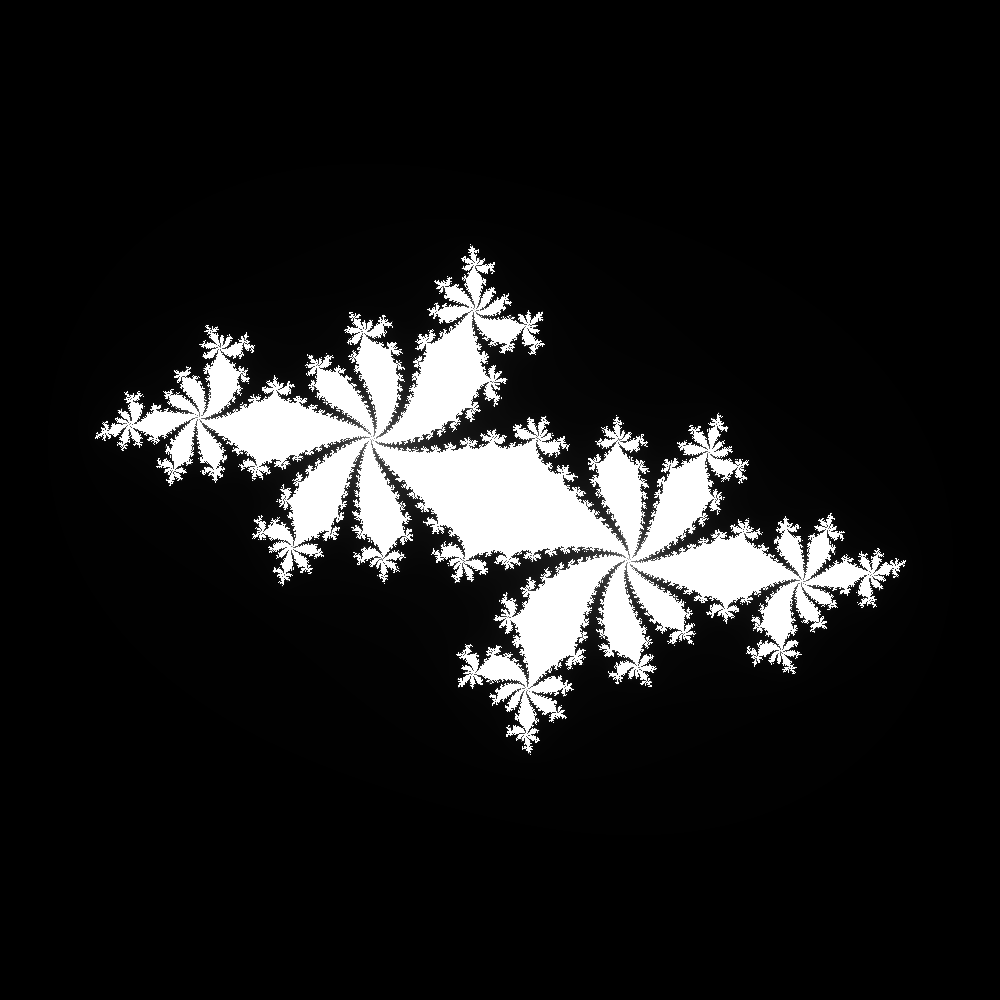

In [4]:
if __name__ == "__main__":
    # Calculate the Julia set using a pure Python solution with
    # reasonable defaults for a laptop
    # set draw_output to True to use PIL to draw an image
    calc_pure_python(draw_output=True, desired_width=1000, max_iterations=300)

If we chose a different c, we’d get a different image. The location we have chosen has regions that are quick to calculate and others that are slow to calculate; this is useful for our analysis.

The problem is interesting because we calculate each pixel by applying a loop that could be applied an indeterminate number of times. On each iteration we test to see if this coordinate’s value escapes toward infinity, or if it seems to be held by an attractor. Coordinates that cause few iterations are colored darkly, and those that cause a high number of iterations are colored white. White regions are more complex to calculate and so take longer to generate.



### Defining a decorator to automate timing measurements

In [7]:
import time
from functools import wraps

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193


def timefn(fn):
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        print(f"@timefn: {fn.__name__} took {t2 - t1} seconds")
        return result
    return measure_time


@timefn
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output


def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex co-ordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # build a list of co-ordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our function
    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    assert sum(output) == 33219980  # this sum is expected for 1000^2 grid with 300 iterations


# Calculate the Julia set using a pure Python solution with
# reasonable defaults for a laptop
# set draw_output to True to use PIL to draw an image
calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)

Length of x: 1000
Total elements: 1000000
@timefn: calculate_z_serial_purepython took 9.224093198776245 seconds
calculate_z_serial_purepython took 9.22429871559143 seconds


### Using the cProfile Module

In [9]:
%%writefile julia.py
import time

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193


def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output


def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex co-ordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # build a list of co-ordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our function
    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    assert sum(output) == 33219980  # this sum is expected for 1000^2 grid with 300 iterations


# Calculate the Julia set using a pure Python solution with
# reasonable defaults for a laptop
# set draw_output to True to use PIL to draw an image
calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)

Overwriting julia.py


In [11]:
!python -m cProfile -s cumulative julia.py

Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 12.222833395004272 seconds
         36221995 function calls in 13.123 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   13.123   13.123 {built-in method builtins.exec}
        1    0.034    0.034   13.123   13.123 julia.py:1(<module>)
        1    0.675    0.675   13.090   13.090 julia.py:22(calc_pure_python)
        1    8.879    8.879   12.223   12.223 julia.py:8(calculate_z_serial_purepython)
 34219980    3.344    0.000    3.344    0.000 {built-in method builtins.abs}
  2002000    0.185    0.000    0.185    0.000 {method 'append' of 'list' objects}
        1    0.007    0.007    0.007    0.007 {built-in method builtins.sum}
        3    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 {built-in method time.time}
        4    0.000    0.000    0.000    0.

In [12]:
!python -m cProfile -o profile.stats julia.py

Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 11.908268213272095 seconds


In [14]:
import pstats
p = pstats.Stats("profile.stats")
p.sort_stats("cumulative")
p.print_stats()

Tue Sep  7 13:08:41 2021    profile.stats

         36221995 function calls in 12.747 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   12.747   12.747 {built-in method builtins.exec}
        1    0.034    0.034   12.747   12.747 julia.py:1(<module>)
        1    0.623    0.623   12.713   12.713 julia.py:22(calc_pure_python)
        1    8.597    8.597   11.908   11.908 julia.py:8(calculate_z_serial_purepython)
 34219980    3.311    0.000    3.311    0.000 {built-in method builtins.abs}
  2002000    0.175    0.000    0.175    0.000 {method 'append' of 'list' objects}
        1    0.007    0.007    0.007    0.007 {built-in method builtins.sum}
        3    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 {built-in method time.time}
        4    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.00

In [15]:
p.print_callers()

   Ordered by: cumulative time

Function                                          was called by...
                                                      ncalls  tottime  cumtime
{built-in method builtins.exec}                   <- 
julia.py:1(<module>)                              <-       1    0.034   12.747  {built-in method builtins.exec}
julia.py:22(calc_pure_python)                     <-       1    0.623   12.713  julia.py:1(<module>)
julia.py:8(calculate_z_serial_purepython)         <-       1    8.597   11.908  julia.py:22(calc_pure_python)
{built-in method builtins.abs}                    <- 34219980    3.311    3.311  julia.py:8(calculate_z_serial_purepython)
{method 'append' of 'list' objects}               <- 2002000    0.175    0.175  julia.py:22(calc_pure_python)
{built-in method builtins.sum}                    <-       1    0.007    0.007  julia.py:22(calc_pure_python)
{built-in method builtins.print}                  <-       3    0.000    0.000  julia.py:22(calc_pure_

In [16]:
p.print_callees()

   Ordered by: cumulative time

Function                                          called...
                                                      ncalls  tottime  cumtime
{built-in method builtins.exec}                   ->       1    0.034   12.747  julia.py:1(<module>)
julia.py:1(<module>)                              ->       1    0.623   12.713  julia.py:22(calc_pure_python)
julia.py:22(calc_pure_python)                     ->       1    8.597   11.908  julia.py:8(calculate_z_serial_purepython)
                                                           2    0.000    0.000  {built-in method builtins.len}
                                                           3    0.000    0.000  {built-in method builtins.print}
                                                           1    0.007    0.007  {built-in method builtins.sum}
                                                           2    0.000    0.000  {built-in method time.time}
                                                     

### Visualizing cProfile Output with SnakeViz

In [ ]:
!pip install snakeviz

In [19]:
%load_ext snakeviz

In [37]:
!nohup snakeviz profile.stats -p 5061 -s &

nohup: appending output to 'nohup.out'


### Using line_profiler for Line-by-Line Measurements

In [48]:
!pip install line_profiler

     |████████████████████████████████| 63 kB 1.7 MB/s 


In [51]:
%%writefile julia_lprof.py
import time

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193


@profile
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while True:
            not_yet_escaped = abs(z) < 2
            iterations_left = n < maxiter
            if not_yet_escaped and iterations_left:
                z = z * z + c
                n += 1
            else:
                break
        output[i] = n
    return output


@profile
def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex co-ordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # set width and height to the generated pixel counts, rather than the
    # pre-rounding desired width and height
    # build a list of co-ordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our function
    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    assert sum(output) == 33219980  # this sum is expected for 1000^2 grid with 300 iterations



# Calculate the Julia set using a pure Python solution with
# reasonable defaults for a laptop
# set draw_output to True to use PIL to draw an image
calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)

Writing julia_lprof.py


In [52]:
!kernprof -l -v julia_lprof.py

Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 170.90350127220154 seconds
Wrote profile results to julia_lprof.py.lprof
Timer unit: 1e-06 s

Total time: 92.4686 s
File: julia_lprof.py
Function: calculate_z_serial_purepython at line 8

Line #      Hits         Time  Per Hit   % Time  Line Contents
     8                                           @profile
     9                                           def calculate_z_serial_purepython(maxiter, zs, cs):
    10                                               """Calculate output list using Julia update rule"""
    11         1       2693.0   2693.0      0.0      output = [0] * len(zs)
    12   1000001     504755.0      0.5      0.5      for i in range(len(zs)):
    13   1000000     459967.0      0.5      0.5          n = 0
    14   1000000     539772.0      0.5      0.6          z = zs[i]
    15   1000000     499420.0      0.5      0.5          c = cs[i]
    16   1000000     467458.0      0.5      0.5          

### Using memory_profiler to Diagnose Memory Usage

In [55]:
!pip install memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-py3-none-any.whl size=30190 sha256=117295651889445aea0291f56d32368bd4be3745bfa5fd5d1d60c96092fd45df
  Stored in directory: /root/.cache/pip/wheels/56/19/d5/8cad06661aec65a04a0d6785b1a5ad035cb645b1772a4a0882
Successfully built memory-profiler


In [53]:
%%writefile julia_memprof.py
import time

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193


@profile
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while n < maxiter and abs(z) < 2:
            z = z * z + c
            n += 1
        output[i] = n
    return output


@profile
def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex co-ordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # set width and height to the generated pixel counts, rather than the
    # pre-rounding desired width and height
    # build a list of co-ordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our function
    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    assert sum(output) == 33219980  # this sum is expected for 1000^2 grid with 300 iterations


# Calculate the Julia set using a pure Python solution with
# reasonable defaults for a laptop
# set draw_output to True to use PIL to draw an image
#calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)
calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)

Writing julia_memprof.py


In [ ]:
!python -m memory_profiler julia_memprof.py

Length of x: 1000
Total elements: 1000000
